---
Project for the Research Module in Econometrics and Statistics | Winter Semester 2021-2022 | University of Bonn
[Hugo Foerster-Baldenius](https://github.com/hugo-fb) and [Muhammad Danial Syed](https://github.com/CasualDan) <br>

---
# Working tite: Valid Inference using Machine Learning in a semiparametric setting
#### by Hugo Foerster-Baldenius and Muhammad Danial Syed

This notebook contains our project based on Double Machine Learning method introduced in [Double/debiased machine learning for treatment and structural parameters](https://academic.oup.com/ectj/article/21/1/C1/5056401) (Chernozhukov et al., 2018).

#### Viewing the notebook
The best way to view this notebook is to download the entire GitHub repository dedicated to the project, and operating it via Jupyter Notebooks. Mathematical symbols used throughout the notebook will then be rendered properly. <br>

The following packages are used throughout the notebook, so make sure to have them installed prior to running.
- [DoubleML](https://docs.doubleml.org/stable/index.html)
- [MLR3 Learners](https://mlr3learners.mlr-org.com)

#### Source material
The project uses the above DoubleML package for its main computations and also relies on certain modifications of the [source code](https://github.com/DoubleML/doubleml-for-r) to alter the data generating process in testing the confoundedness assumption of the method.

---
## Part 1: Simulation Study
---

### 1. Setup

#### 1.1 Initialization 

In [11]:
rm(list=ls())

library(repr)
library(mlr3)
library(ggplot2)
library(mvtnorm)
library("readxl")
library(DoubleML)
library(mlr3learners)
suppressMessages(library(doMC))
suppressMessages(library(ggplot2))
suppressMessages(library(parallel))
suppressMessages(library(tidyverse))
lgr::get_logger("mlr3")$set_threshold("warn")

numCores <- detectCores()
registerDoMC(cores = numCores)

#### 1.2 Using LASSO as the Machine Learning Method for Estimating $g_{0}$ and $m_{0}$

In [13]:
# LASSO Estimation Function
est_lasso <- function(obj_dml_data) {
    
    set.seed(70)
    learner <- lrn("regr.cv_glmnet", s="lambda.min")
    g_hat <- learner$clone()                                  # use LASSO to estimate nuisance g() and m()
    m_hat <- learner$clone()
    
    DML_PLR  <- DoubleMLPLR$new(obj_dml_data, g_hat, m_hat)   # initialize the DML Partially Linear Model 
    DML_PLR$fit()                                             # Fit the model and extract coefficient estimates
    theta_hat <- DML_PLR$coef
    sd_hat    <- DML_PLR$se
    params    <- cbind(theta_hat,sd_hat)
    return(params)
}

#### 1.3a Default Data Generating Process - Chernozhukov et al. (2018)

In [15]:
generate_DGP <- function(n_obs,dim_x,theta,seed,s=0) {
    
    set.seed(seed)
    #multiplicatives in nuisance functions  
    a_1 = 0.25
    b_1 = 0.25
    
    # standard gaussian noise 
    eps <- rnorm(n_obs)
    ups <- rnorm(n_obs)
    
    # Toeplitz covariance matrix
    cov_mat <- toeplitz(0.7^(0:(dim_x - 1)))
    x       <- rmvnorm(n = n_obs, mean = rep(0, dim_x), sigma = cov_mat) 
    
    # nuisance parameter m_0 and propensity function d  
    m_0_x <- x[,1] + a_1 * (exp(x[,3]) /(1 + exp(x[,3])))
    d     <- as.matrix(m_0_x + eps)
    
    # nuisance paraneter g_0 and outcome y
    beta  <- c(rep(0,3), rnorm(s), rep(0,dim_x-s-3))     # control sparsity of g
    g_0_x <- exp(x[,1]) /(1 + exp(x[,1])) + b_1 * x[,3] +  x %*% beta
    y     <- as.matrix(theta*d + g_0_x + ups)

    # Data prep
    colnames(x) <- paste0("X", 1:dim_x)
    colnames(y) <- "y"
    colnames(d) <- "d"
    data = data.frame(x, y, d)
    return(data)
} 

#### 1.3b Confounded DGP - Hünermund et al (2021)

In [ ]:
# pre treatment confounder: test at n_con = 1, 3, or 5.
confounded_DGP_PRE <- function(n_obs,dim_x,theta,seed,n_con,s=0) {
    
    set.seed(seed)
    a_1 = 0.25
    b_1 = 0.25
    c_1 = 0.8
    c_2 = 0.2
    
    u1  <- rnorm(n_obs)  # unobserved
    u2  <- rnorm(n_obs)  # unobserved correlation with y
    
    # standard gaussian noise 
    eps <- rnorm(n_obs)
    ups <- rnorm(n_obs)
    
    # constructing covariates matrix
    cov_mat <- toeplitz(0.7^(0:(dim_x - 1 - n_con)))
    
    x     <- rmvnorm(n = n_obs, mean = rep(0, dim_x-n_con), sigma = cov_mat)        # covariate matrix, unconfounded
    x_con <- matrix(rnorm(n_obs * n_con), ncol = n_con) + sqrt(c_1) * u1 + sqrt(c_2) * u2    # bad controls
    
    # nuisance parameter m_0 and propensity function d
    m_0_x <- x[,1] + a_1 * (exp(x[,3])/(1 + exp(x[,3]))) 
    d     <- as.matrix(m_0_x + sqrt(c_1) * u1 + eps)
    
    # nuisance paraneter g_0
    beta  <- c(rep(0,4), rep(1,s), rep(0,dim_x-s-4))
    g_0_x <-  exp(x[,1]) /(1 + exp(x[,1])) + b_1 * x[,3] +  x %*% beta
    
    y <- as.matrix(theta*d + g_0_x + sqrt(c_2) * u2 + ups)

    colnames(x) <- paste0("X", 1:dim_x)
    colnames(y) <- "y"
    colnames(d) <- "d"
    data = data.frame(x, y, d)
    return(data)
} 

#### 1.4 Simulation Function

In [16]:
sim_function <- function(data){
    
    DML_data     <- double_ml_data_from_data_frame(data, y_col = "y", d_cols = "d")
    param_output <- est_lasso(DML_data) 
    return(param_output)
}

#### 1.5 Parameter Setup

In [22]:
### Fixed Design Parameters
n_rep = 5000
n_vars = 150
n_obs  = 200
theta  = 1

### 2. Multiple Parts Simulation Study

###  Part I: Testing Different scenarios
- Naive Estimator using LASSO
- DML with and without cross-fitting
- DML with and without endogenous control

#### Scenario 2.1: Naïve Estimate with equal sample split - Figure 1

In [21]:
theta_hat_naive <- rep(NA, n_rep)

# Simulating the estimator 10,000 times with different data each time
for (i in 1:n_rep) {
    data = generate_DGP(theta=theta, n_obs=n_obs, dim_x=n_vars, seed=i) 
    
    task_g  <- TaskRegr$new(id = "data", backend = data, target = "y")
    learner <- lrn("regr.cv_glmnet", s="lambda.min")
    
    train_set <- sample(task_g$nrow, 0.5 * task_g$nrow)
    test_set  <- setdiff(seq_len(task_g$nrow), train_set)

    # train the model
    learner$train(task_g, row_ids = train_set)

    # predict data
    g_hat <- learner$predict(task_g, row_ids = test_set)
    theta_hat_naive[i] <- (mean(data[test_set,]$d*(data[test_set,]$y - g_hat$response)))/mean(data[test_set,]$d^2)

}

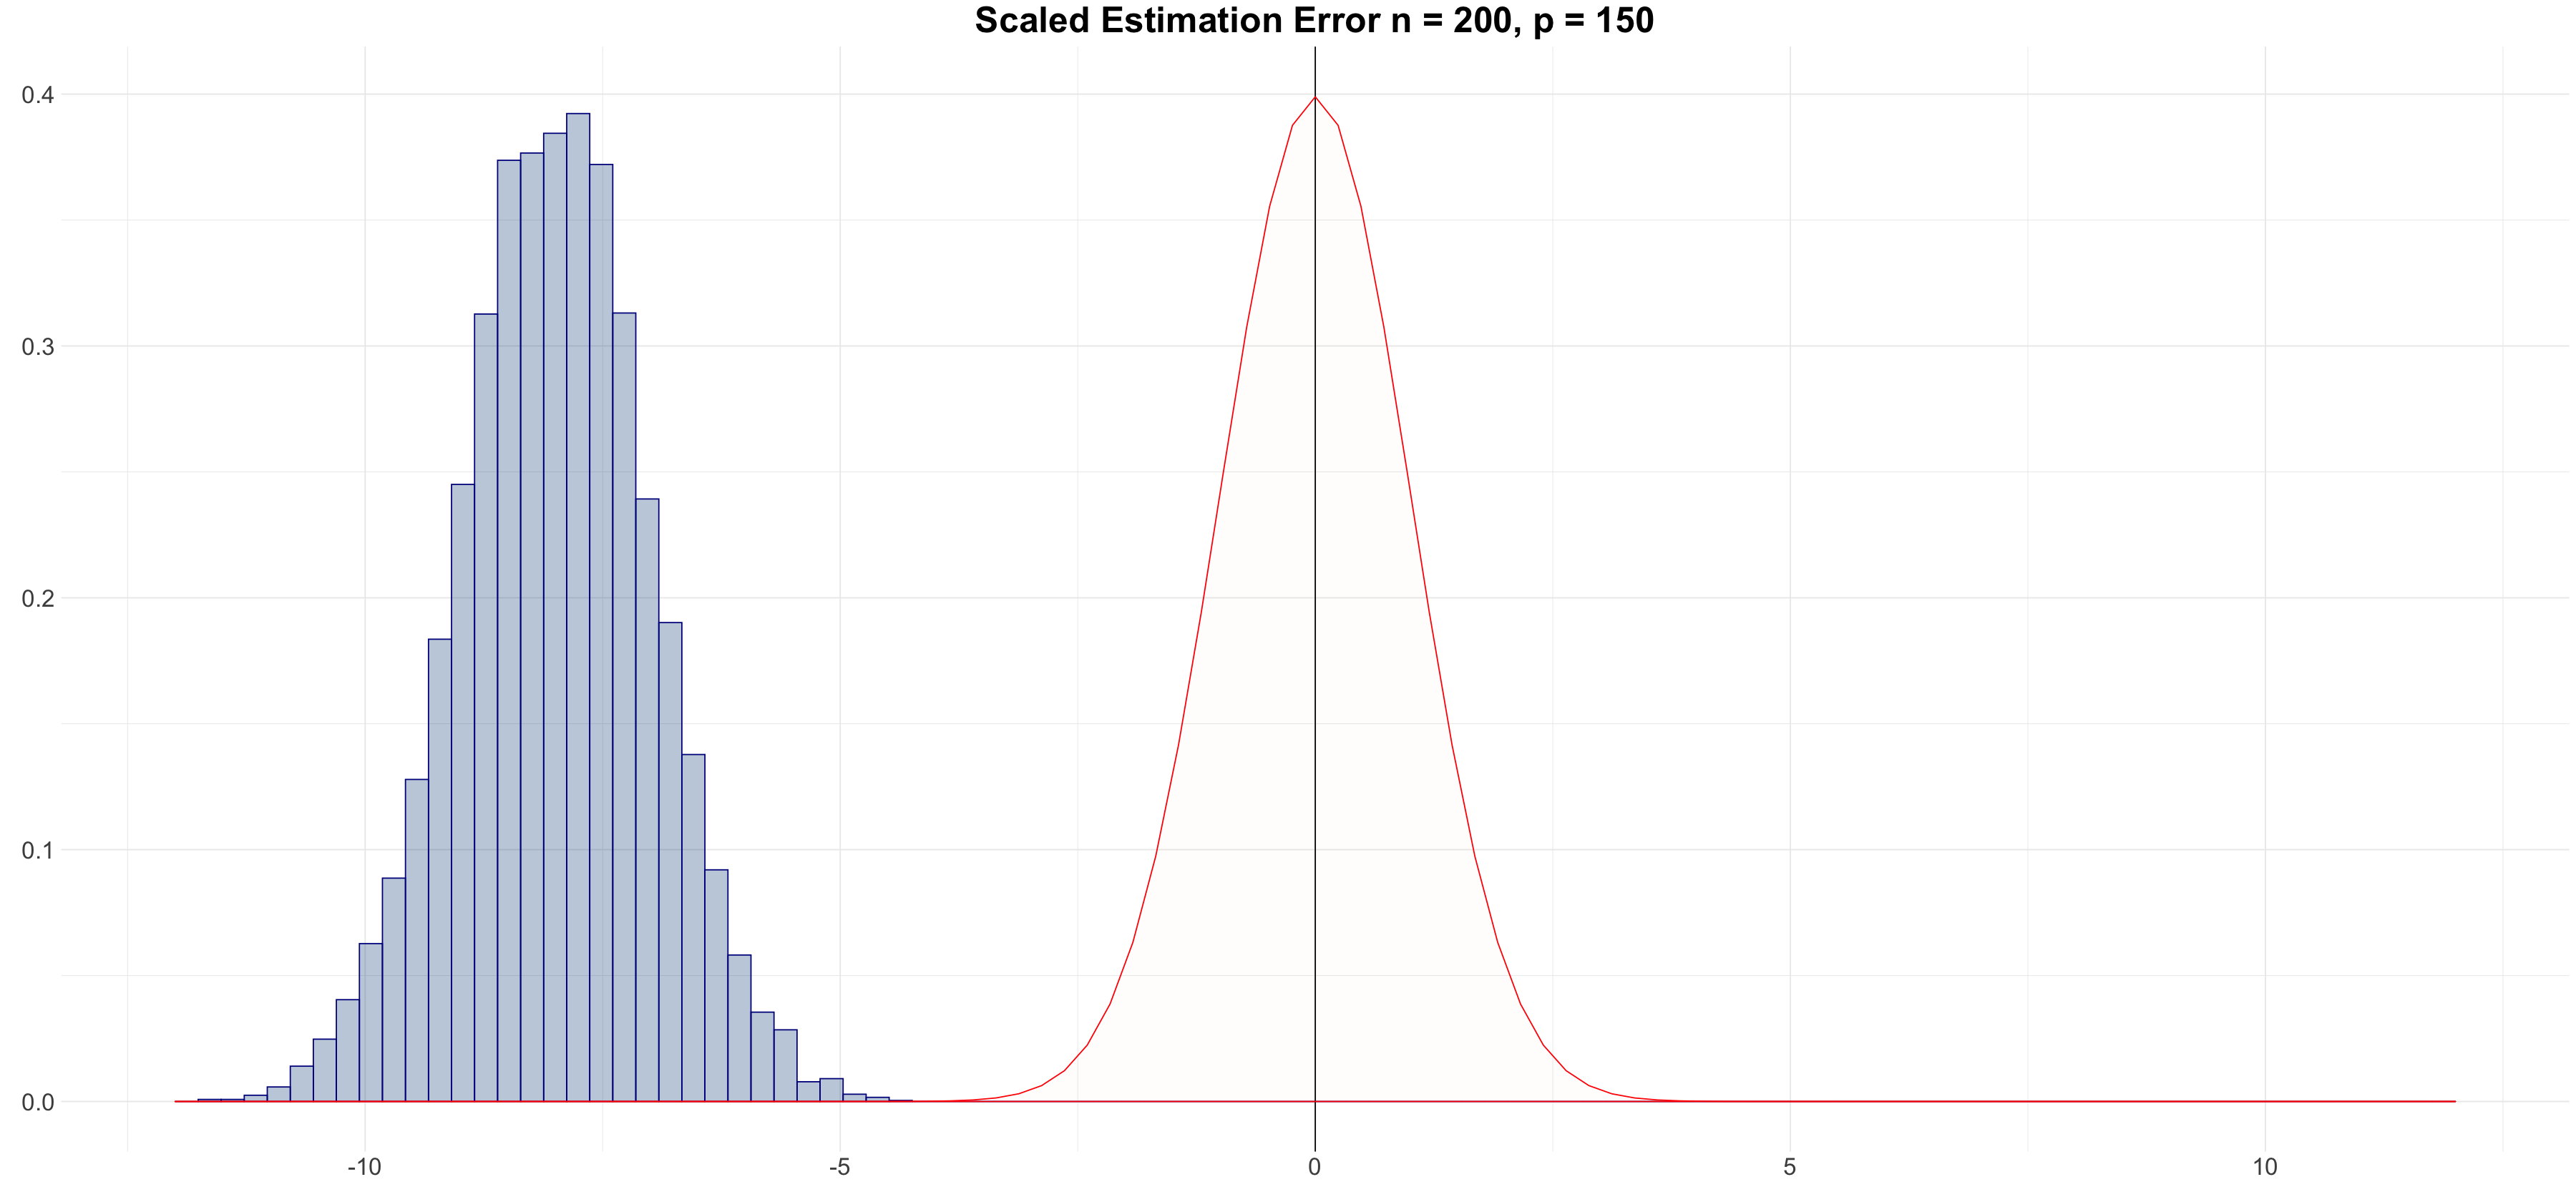

In [23]:
# Plotting the results as a scaled estimation error: significant bias
df_naive = data.frame(theta_hat_naive = theta_hat_naive - theta)
sd_naive = sd(theta_hat_naive)

df_naive_scaled = data.frame("theta_hat_naive" = df_naive$theta_hat_naive/sd_naive)

fig1 = ggplot(df_naive_scaled, aes(x = theta_hat_naive)) +
        geom_histogram(aes(y=..density..), bins = 100, fill = "dodgerblue4", alpha = 0.3, color = "dark blue") +
        geom_vline(aes(xintercept = 0), col = "black") +
        xlim(c(-12, 12)) + xlab("") + ylab("") + theme_minimal() + 
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=20)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Scaled Estimation Error n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

fig1

#### Scenario 2.2: DML Estimator without cross-fitting - Figure 2a

In [ ]:
cross_fx <- function(iteration) {
    
    data = generate_DGP(theta=theta, n_obs=n_obs, dim_x=n_vars, seed=iteration) 
    DML_data <- double_ml_data_from_data_frame(data, y_col = "y", d_cols = "d")
    
    learner <- lrn("regr.cv_glmnet", s="lambda.min")
    g_hat   <- learner$clone()                                
    m_hat   <- learner$clone()
    
    DML_PLR  <- DoubleMLPLR$new(DML_data, g_hat, m_hat, n_folds=1, apply_cross_fitting=FALSE) 
    DML_PLR$fit() 
    theta_hat <- DML_PLR$coef                           
    return(theta_hat) 
}

theta_hat_orth_nosplit  <- mclapply(1:n_rep, cross_fx, mc.set.seed = TRUE, mc.cores = numCores)
theta_hat_orth_nosplit  <- do.call(rbind, theta_hat_orth_nosplit)

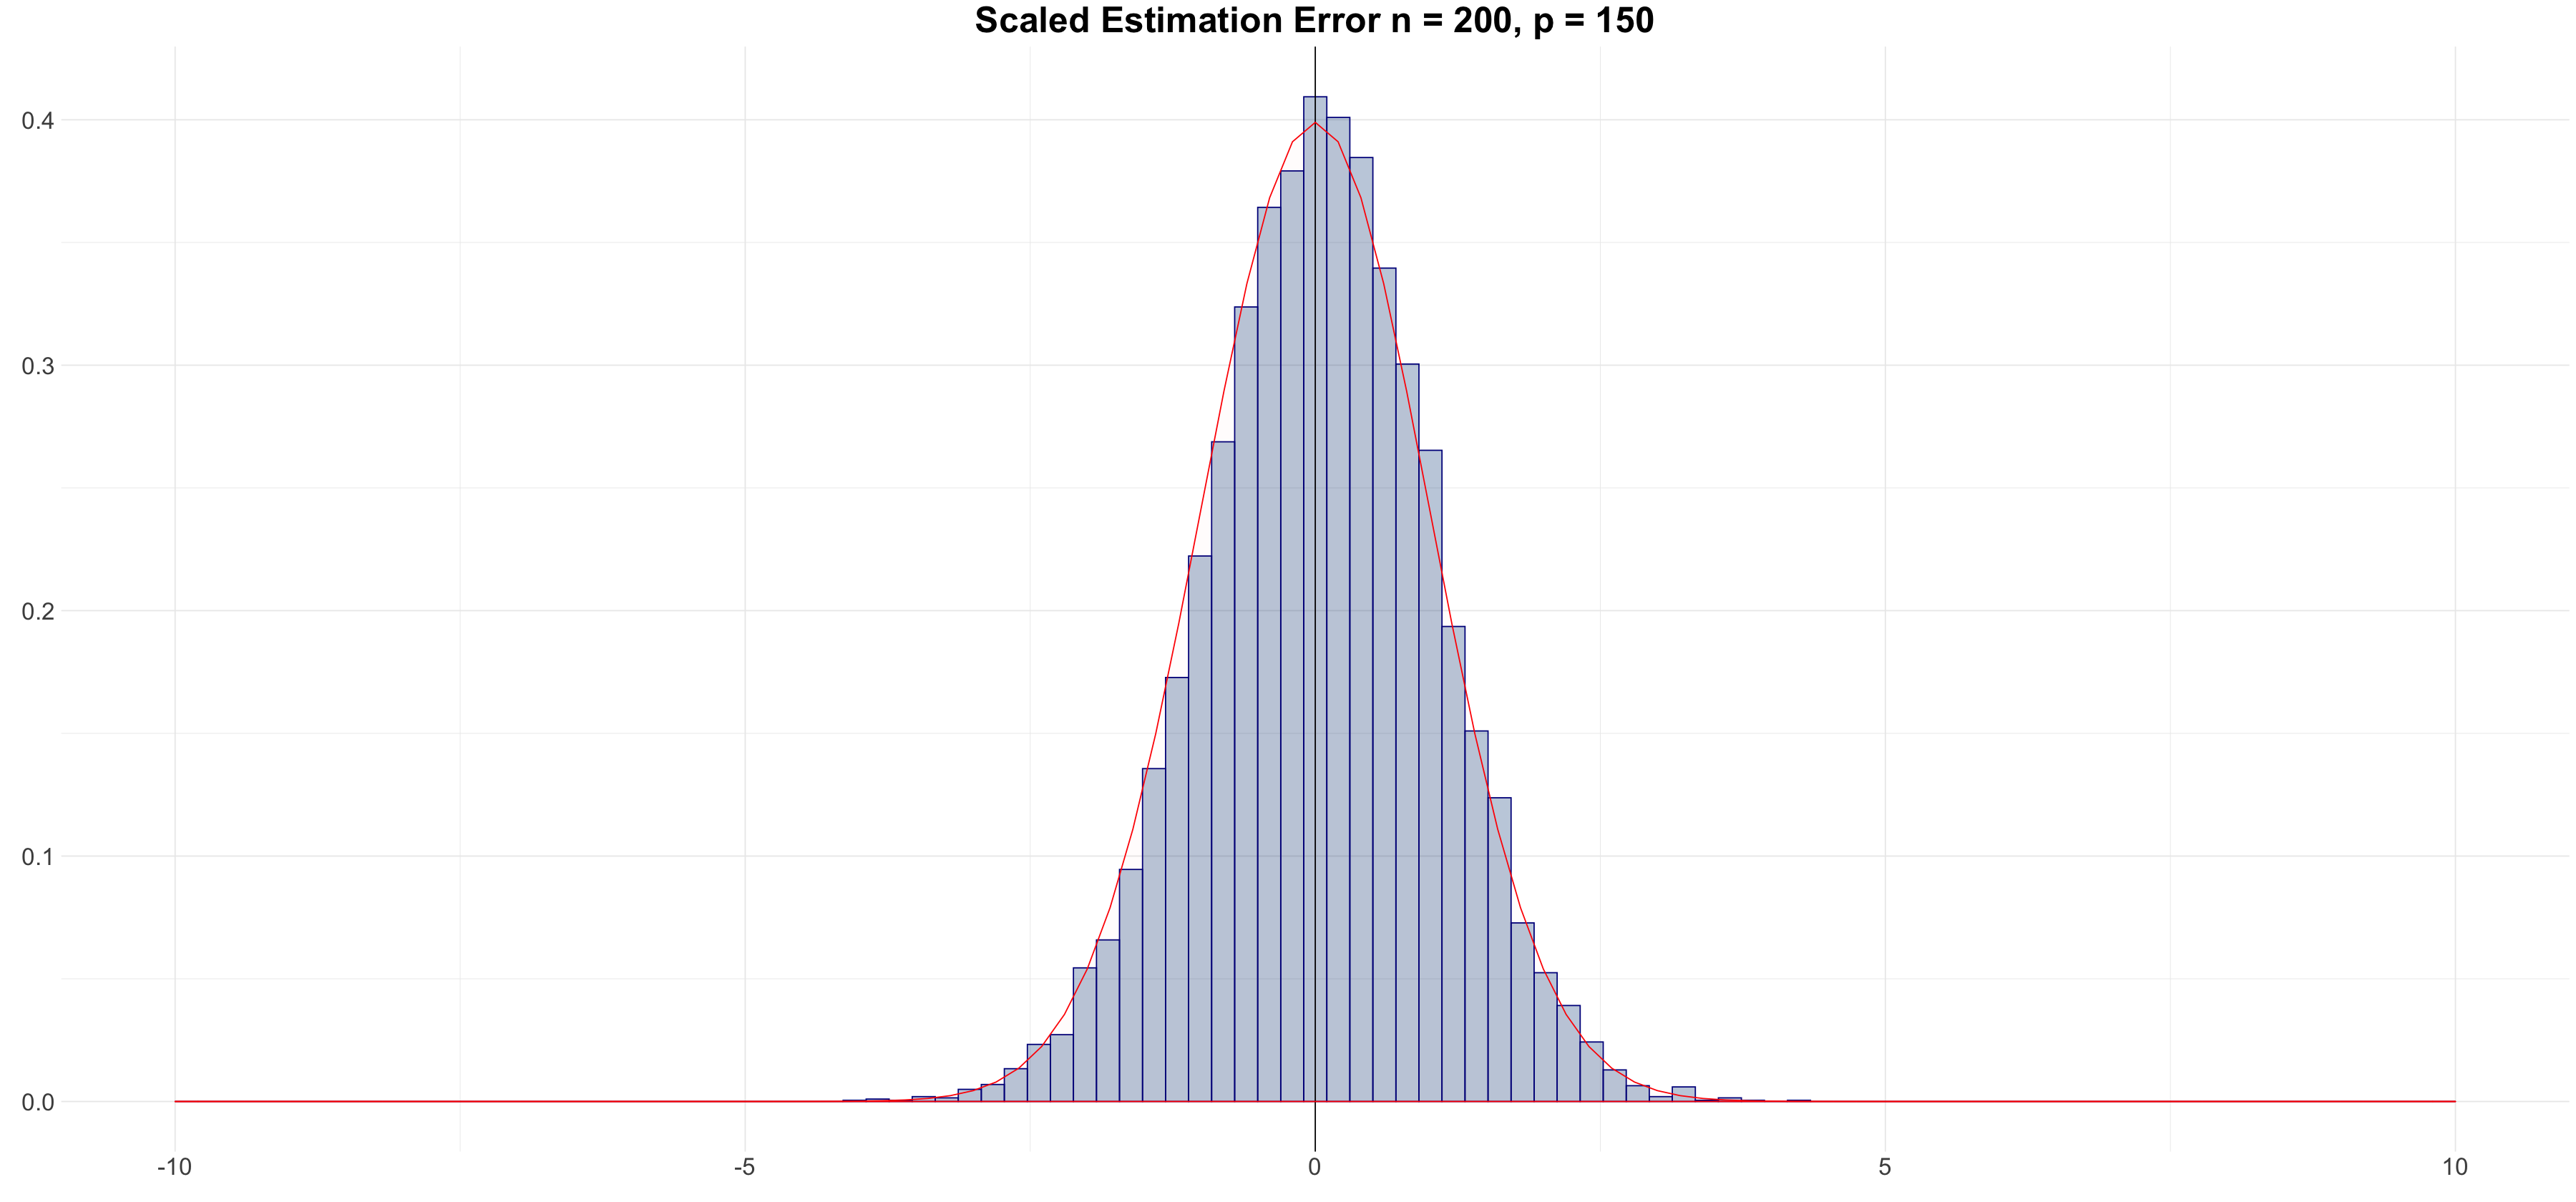

In [40]:
# Plotting the distribution of scaled estimation from Case 1: No unconfoundedness
df_nosplit = data.frame(theta_hat_orth_nosplit = theta_hat_orth_nosplit - theta)
sd_nosplit = sd(theta_hat_orth_nosplit)

df_nosplit = data.frame("theta_hat_orth_nosplit" = df_nosplit$d/sd_nosplit)

fig2a = ggplot(df_nosplit, aes(x = theta_hat_orth_nosplit)) +
        geom_histogram(aes(y=..density..), bins = 100, fill = "dodgerblue4", alpha = 0.3, color = "dark blue") +
        geom_vline(aes(xintercept = 0), col = "black") +
        xlim(c(-10, 10)) + xlab("") + ylab("") + theme_minimal() + 
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=20)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Scaled Estimation Error n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

fig2a

#### Scenario 2.2b: DML Estimator with cross-fitting - Figure 2b

In [ ]:
boot_fx <- function(iteration) {
    data = generate_DGP(theta=theta,n_obs=n_obs,dim_x=n_vars,seed=iteration) # use default DGP provided in packages (chernozhukov 2018)
    theta_estim <- sim_function(data)[1]  
    return(theta_estim) 
}

theta_hat_orth_split <- mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
theta_hat_orth_split <- do.call(rbind, parallel_estims)

In [ ]:
# Plotting the distribution of scaled estimation for DML with cross-fitting
df_split = data.frame(theta_hat_orth_split = theta_hat_orth_split - theta)
sd_split = sd(theta_hat_orth_split)

df_split = data.frame("theta_hat_orth_split" = df_split$d/sd_split)

fig2b = ggplot(df_split, aes(x = theta_hat_orth_split)) +
        geom_histogram(aes(y=..density..), bins = 100, fill = "dodgerblue4", alpha = 0.3, color = "dark blue") +
        geom_vline(aes(xintercept = 0), col = "black") +
        xlim(c(-10, 10)) + xlab("") + ylab("") + theme_minimal() + 
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=20)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Scaled Estimation Error n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

fig2b

#### Scenario 2.3a: DML Estimator with pre-treatment confounder - Figure 3a

In [ ]:
n_con = 1

boot_fx <- function(iteration) {
        
    data = confounded_DGP_PRE(theta=theta,n_obs=n_obs,dim_x=n_vars,seed=iteration,n_con=n_con) # use default DGP provided in packages (chernozhukov 2018)
    theta_estim <- sim_function(data)[1]  
    return(theta_estim) 
}

combined_vec  <- mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
all_estimates_confound <- do.call(rbind, combined_vec)

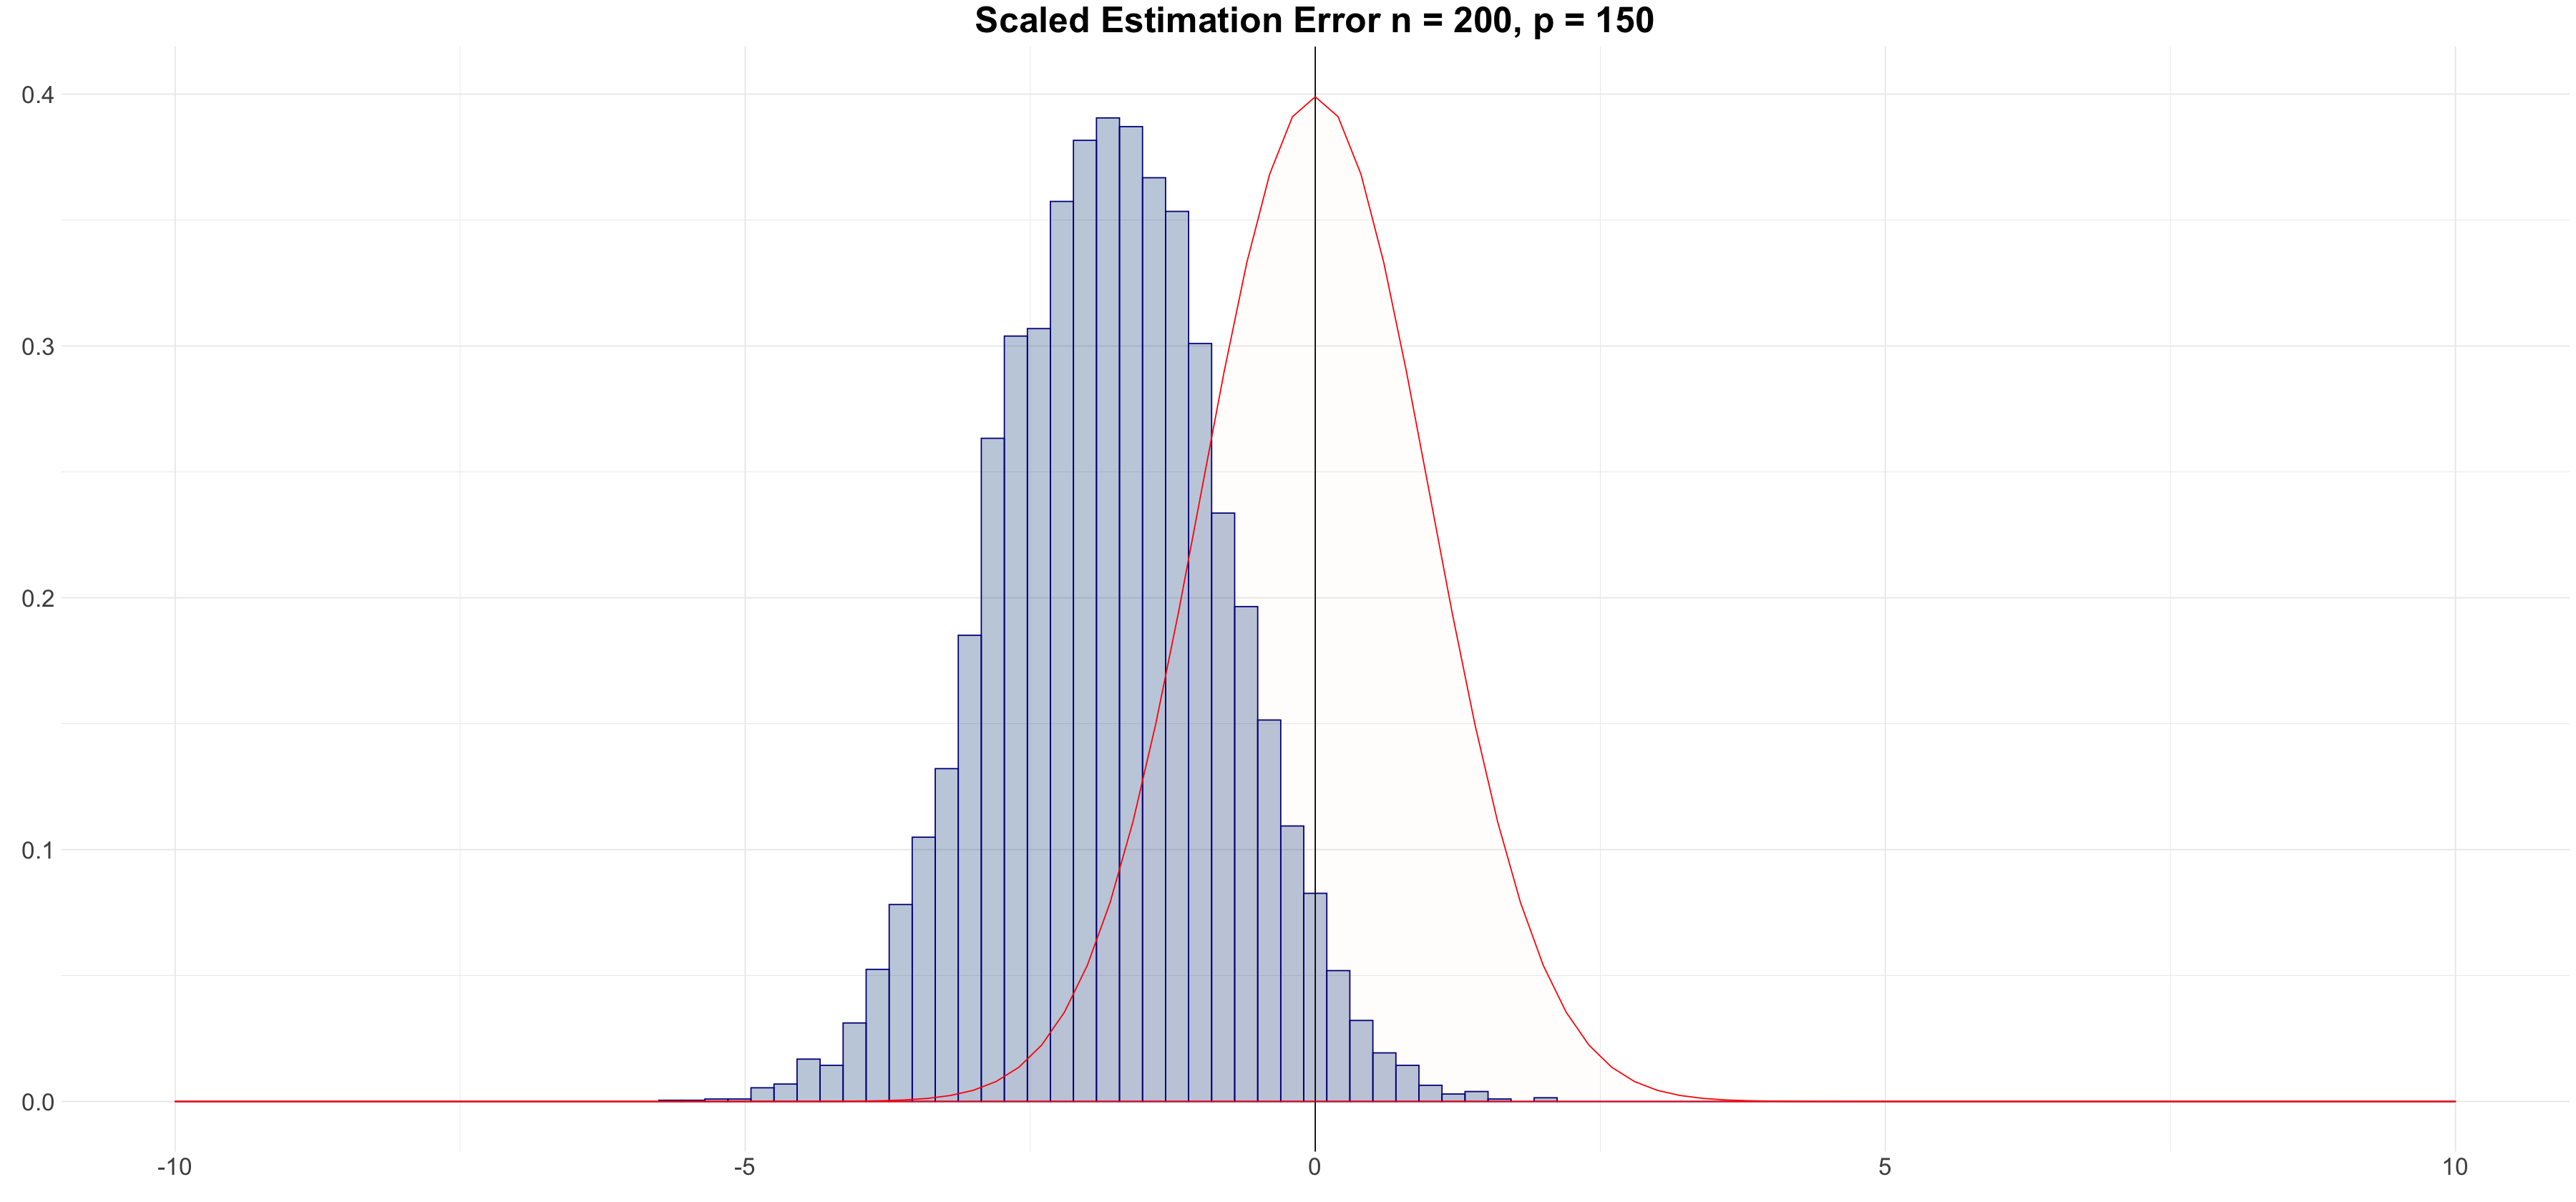

In [244]:
# Plotting the distribution of scaled estimation from Case 1: No unconfoundedness
theta_hat_confound <- all_estimates_confound
df_confound = data.frame(theta_hat_confound = theta_hat_confound - theta)
sd_confound = sd(theta_hat_confound)

df_confound_scaled = data.frame("theta_hat_confound" = df_confound$d/sd_confound)

fig3a = ggplot(df_confound_scaled, aes(x = theta_hat_confound)) +
        geom_histogram(aes(y=..density..), bins = 100, fill = "dodgerblue4", alpha = 0.3, color = "dark blue") +
        geom_vline(aes(xintercept = 0), col = "black") +
        xlim(c(-10, 10)) + xlab("") + ylab("") + theme_minimal() + 
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=20)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Scaled Estimation Error n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

fig3a

#### Scenario 2.3b: DML Estimator with pre-treatment confounder excluded from dataset - Figure 3b

In [274]:
n_con = 0

boot_fx <- function(iteration) {
        
    data = confounded_DGP_PRE(theta=theta,n_obs=n_obs,dim_x=n_vars,seed=iteration,n_con=n_con) # use default DGP provided in packages (chernozhukov 2018)
    theta_estim <- sim_function(data)[1]  
    return(theta_estim)  
}

combined_vec  <- mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
all_estimates_no_confound <- do.call(rbind, combined_vec)

Warning message in mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores):
“all scheduled cores encountered errors in user code”


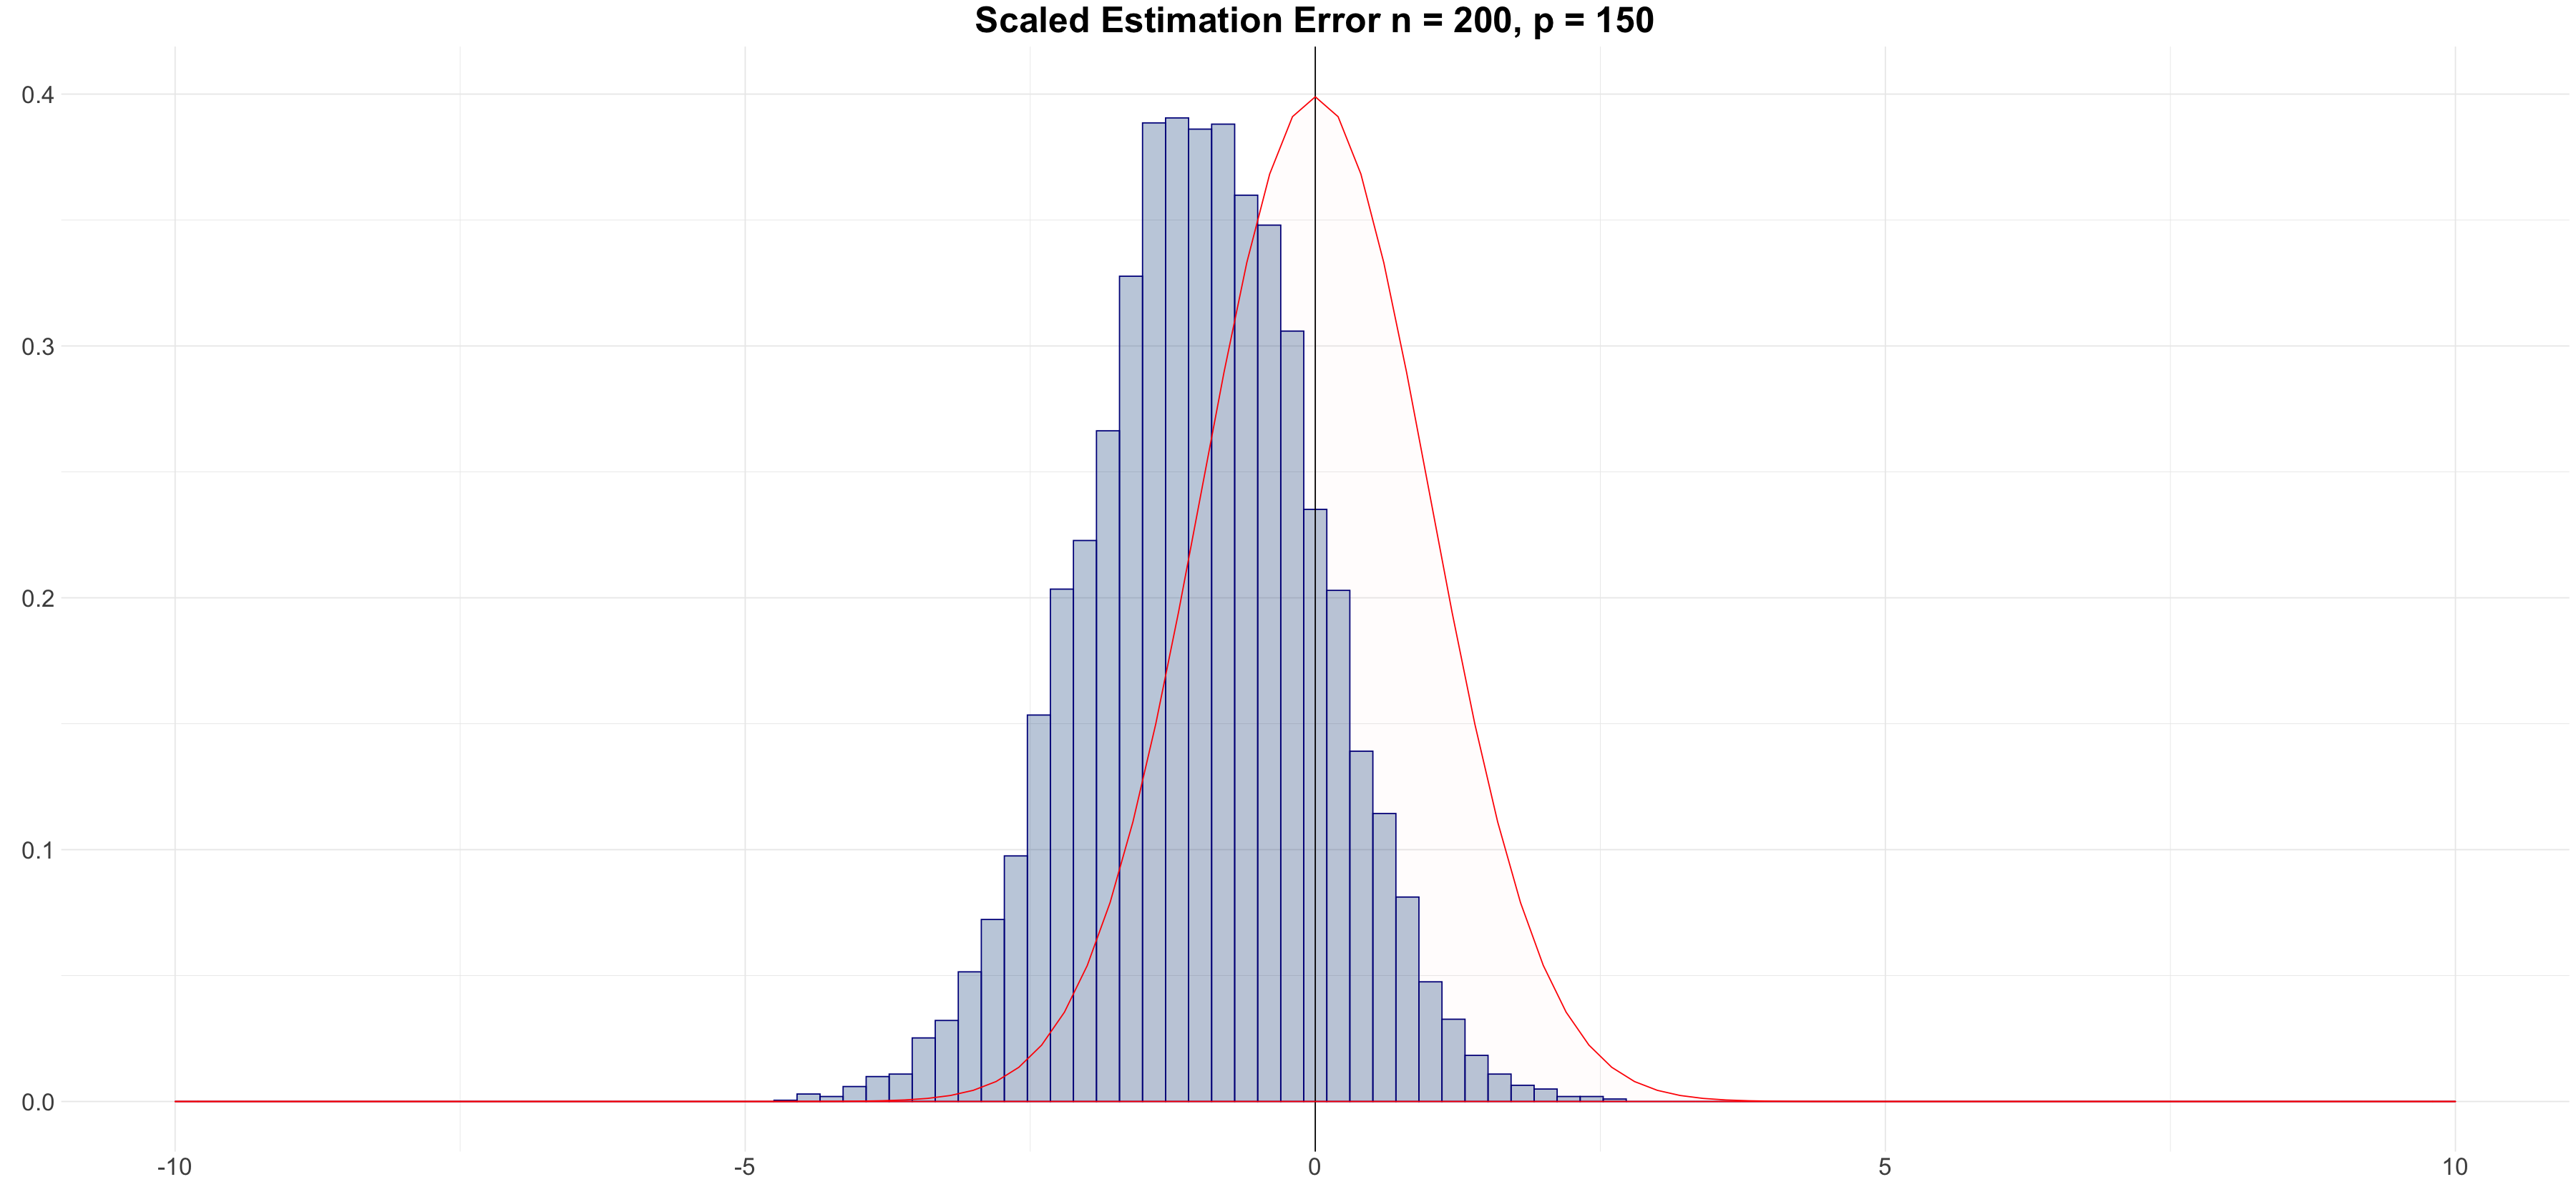

In [272]:
# Plotting the distribution of scaled estimation from Case 1: No unconfoundedness
theta_hat_no_confound <- all_estimates_no_confound
df_no_confound = data.frame(theta_hat_no_confound = theta_hat_no_confound - theta)
sd_no_confound = sd(theta_hat_no_confound)

df_no_confound_scaled = data.frame("theta_hat_no_confound" = df_no_confound$d/sd_no_confound)

fig3b = ggplot(df_no_confound_scaled, aes(x = theta_hat_no_confound)) +
        geom_histogram(aes(y=..density..), bins = 100, fill = "dodgerblue4", alpha = 0.3, color = "dark blue") +
        geom_vline(aes(xintercept = 0), col = "black") +
        xlim(c(-10, 10)) + xlab("") + ylab("") + theme_minimal() + 
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=20)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Scaled Estimation Error n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

fig3b

### Part II: Asymptotics
- Consistency
- Asymptotic Normality
- 
- 

#### Consistency

In [ ]:
### Update Design Parameters
n_rep  = 50

samples <- seq(30,1000,by=10)
consistent_estims <- matrix(NA, nrow=length(samples), ncol=n_rep)

In [ ]:
for (i in 1:length(samples)) {
    
    boot_fx <- function(iteration) {        
        data        <- generate_DGP(theta=theta,n_obs=samples[i],dim_x=n_vars,seed=iteration)
        theta_estim <- sim_function(data)[1]  
        return(theta_estim) 
    }
    
    parallel_estims         <- mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
    consistent_estims[i,] <- do.call(cbind, parallel_estims)

} 

In [ ]:
df <- data.frame(Index = 1:length(samples),consistent_estims)
df <- melt(df,id.vars = 'Index',variable.name = 'series')

ggplot(df, aes(Index,value)) + 
    geom_line(aes(colour = series), size = 0.25) + theme_minimal() + 
        theme(legend.position = "none", plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=25)) +
        ggtitle(paste0("Consistency of DML Estimator")) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

#### Asymptotic Normality

In [ ]:
### Update Design Parameters
n_rep  = 2500

### Varied sample sizes
n_obs_vec = c(30,50,200,500)
normality_estims <- matrix(NA,nrow=n_rep,ncol=length(n_obs_vec))

In [ ]:
for (i in 1:length(n_obs_vec)) {
   
    boot_fx <- function(iteration) {        
        data        <- generate_DGP(theta=theta,n_obs=n_obs_vec[i],dim_x=n_vars,seed=iteration)
        theta_estim <- sim_function(data)[1]  
        return(theta_estim) 
    }
    
    parallel_estims         <- mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
    normality_estims[,i] <- do.call(rbind, parallel_estims)
    
}

In [ ]:
a =  (normality_estims[,1] - theta)
b =  (normality_estims[,2] - theta)
c =  (normality_estims[,3] - theta)
d =  (normality_estims[,4] - theta)

collapse <- data.frame(c(rep(paste0("n = ", n_obs_vec[1]),n_rep),
                         rep(paste0("n = ", n_obs_vec[2]),n_rep),
                         rep(paste0("n = ", n_obs_vec[3]),n_rep),
                         rep(paste0("n = ", n_obs_vec[4]),n_rep)),c(a,b,c,d))

colnames(collapse)<-c("Sample.Sizes","Distribution")

ggplot(collapse, aes(x=Distribution,color=Sample.Sizes)) +
        geom_density(lwd = 2,linetype = 1) +
        #xlim(c(-5, 5)) + ylim(c(0, 0.45)) + 
        xlab("mu") + ylab("") + theme_minimal() + 
        theme(legend.key.size = unit(1, 'cm'),legend.text = element_text(size=30)) +
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=25)) +
        #stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Asymptotic Normality at Select Samples")) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

In [ ]:
a = (normality_estims[,1] - theta)/sd((normality_estims[,1]))
b = (normality_estims[,2] - theta)/sd((normality_estims[,2]))
c = (normality_estims[,3] - theta)/sd((normality_estims[,3]))
d = (normality_estims[,4] - theta)/sd((normality_estims[,4]))

collapse <- data.frame(c(rep(paste0("n = ", n_obs_vec[1]),n_rep),
                         rep(paste0("n = ", n_obs_vec[2]),n_rep),
                         rep(paste0("n = ", n_obs_vec[3]),n_rep),
                         rep(paste0("n = ", n_obs_vec[4]),n_rep)),c(a,b,c,d))

colnames(collapse)<-c("Sample.Sizes","Distribution")

ggplot(collapse, aes(x=Distribution,color=Sample.Sizes)) +
        geom_density(lwd = 2,linetype = 1) +
        #xlim(c(-5, 5)) + ylim(c(0, 0.45)) + 
        xlab("mu") + ylab("") + theme_minimal() + 
        theme(legend.key.size = unit(1, 'cm'),legend.text = element_text(size=30)) +
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=25)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.1) + 
        ggtitle(paste0("Asymptotic Normality at Select Samples")) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

### Part III: DML Finite Sample Sensitivity to k-Fold Sample Splitting
- (in seperate notebook)

---
## Part 2: Empirical Application
---